# CS 6476 Assignment 2 | Part 2: Convolutional Neural Networks



# AIM
 The aim of this assignment is to implement a convolutional neural network from scratch on CIFAR-10 image classification dataset.

# Summary
The goal of this part of the assignment is to provide hands-on experience with coding convolutional neural networks from scratch in pytorch. Similar to the part one, this part is also structured to iterate over the components involved.
Firstly we implement convolution layer followed by max pooling layer. Then we combine these layers along with an activation function (like ReLU) to create a custom layer that we can further use to build a large network.
Finally we train our final model on CIFAR-10 image classification dataset, assess the accuracy of our model and answer some questions regarding the same.

## Learning Objectives
- First Prinicipal coding of a layered CNN
- Develope basic understanding of components of CNN
- Develope basic uderstanding of hyperparameters and training

## Grading Schema
This part of the assignment will be graded out of 100. A good representative of the testcases are already provided in the notebook.
- Conv Layer (10)
- Max Pool Layer (10)
- Combining Layers (10)
- ThreeConvnet Loss (20)
- ThreeConvnet Gradient (5)
- ThreeConvnet Overfitting (7.5)
- ThreeConvnet One Epoch Training (7.5)
- ThreeConvnet Hyperparameter Tuning (30)


## Time Commitement
This part of the assignment should take about 6 hrs of effort to finish. Half of the time estimate is for the associated readings to get a better understanding of the concepts and how it can be coded.



## Computational Requirements
Most cells of this assignment should not take more that 2-3 mins (on CPU) to execute except the last section where you train the model of your hyperparameter choice. Depending on different model parameters, training time is going to significantly vary.

TRICK: Since google colab has a limit on daily free GPU usage. We recommend you to first run your entire notebook on CPU to make sure everything is implemented correctly. Then for the last section you can change the 'runtype' to GPU and the 'DEVICE' parameter to 'cuda' for training your own network. Make sure to save the weights after training.

## Setting Up
First, run the following cell to load the "autoreload" extension. The "autoreload" extension allows you to automatically reload (re-import) Python modules that you've imported or defined when they change. This is particularly useful when you are actively developing or modifying code in external modules and want those changes to be automatically reflected in your notebook without manually restarting the kernel.

In [ ]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the assignment:

```
['convolutional_networks.py', 'fully_connected_networks.py', 'a2_helper.py', 'fully_connected_networks.ipynb', 'cs6476', 'convolutional_networks.ipynb']
```

In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a CV2023 folder and put all the files under A2 folder, then 'CV2023/A2'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CS 6476 Intro to Computer Vision/Assignment 2' #enter file name as the above example
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['convolutional_networks.ipynb', 'simple_models.py', 'a2_helper.py', 'cs6476', '__pycache__', 'simple_models.ipynb', 'resnet.pth', 'transfer_learning.ipynb', 'fully_connected_networks.py', 'final_threeconvnet.pth', 'fully_connected_networks.ipynb', 'convolutional_networks.py']


Once you have successfully mounted your Google Drive and located the path to this assignment, run the following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from convolutional_networks.py!
Hello from a3_helper.py!
```

as well as the last edit time for the file `convolutional_networks.py`.

In [ ]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

from convolutional_networks import hello_convolutional_networks
hello_convolutional_networks()

from a2_helper import hello_helper
hello_helper()

convolutional_networks_path = os.path.join(GOOGLE_DRIVE_PATH, 'convolutional_networks.py')
convolutional_networks_edit_time = time.ctime(os.path.getmtime(convolutional_networks_path))
print('convolutional_networks.py last edited on %s' % convolutional_networks_edit_time)

Hello from convolutional_networks.py!
Hello from a2_helper.py!
convolutional_networks.py last edited on Mon Sep 18 22:44:51 2023


# Data preprocessing

## Imports
Here we import some useful packages and increase the default figure size.

In [ ]:
import cs6476
import torch
import torchvision
import matplotlib.pyplot as plt
import statistics
import random
import time
import math
%matplotlib inline

from cs6476 import reset_seed, Solver

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

In [ ]:
DEVICE = 'cpu'

Run this cell to check if you are using a GPU. Don't use GPU if you want to save on your daily GPU usage.

In [ ]:
if torch.cuda.is_available():
  DEVICE = 'cuda'
  print('Good to go!')
else:
  print('If you want to use GPU then set it via Edit -> Notebook Settings -> Hardware accelerator -> T4 GPU')

If you want to use GPU then set it via Edit -> Notebook Settings -> Hardware accelerator -> T4 GPU


IMPORTANT: If you have reached the GPU usage limit then 'connect without GPU' and change the DEVICE variable in the below cell to 'cpu'. Else make sure to set DEVICE to 'cuda'

In [ ]:
# DEVICE = 'cpu'
# uncomment above if GPU is not avaible

DEVICE = 'cuda'
# uncomment above if gpu is avaible

## Load the CIFAR-10 dataset
Then, we will first load the CIFAR-10 dataset, same as knn. The utility function `get_CIFAR10_data()` in `helper_functions` returns the entire CIFAR-10 dataset as a set of six **Torch tensors** while also preprocessing the RGB images:

- `X_train` contains all training images (real numbers in the range $[0, 1]$)
- `y_train` contains all training labels (integers in the range $[0, 9]$)
- `X_val` contains all validation images
- `y_val` contains all validation labels
- `X_test` contains all test images
- `y_test` contains all test labels

In [ ]:
# Invoke the above function to get our data.
cs6476.reset_seed(903322690)
data_dict = cs6476.data.preprocess_cifar10(cuda=False, dtype=torch.float64, flatten=False)
print('Train data shape: ', data_dict['X_train'].shape)
print('Train labels shape: ', data_dict['y_train'].shape)
print('Validation data shape: ', data_dict['X_val'].shape)
print('Validation labels shape: ', data_dict['y_val'].shape)
print('Test data shape: ', data_dict['X_test'].shape)
print('Test labels shape: ', data_dict['y_test'].shape)

100%|██████████| 170498071/170498071 [00:02<00:00, 59284812.71it/s]


Extracting ./cifar-10-python.tar.gz to .
Train data shape:  torch.Size([40000, 3, 32, 32])
Train labels shape:  torch.Size([40000])
Validation data shape:  torch.Size([10000, 3, 32, 32])
Validation labels shape:  torch.Size([10000])
Test data shape:  torch.Size([10000, 3, 32, 32])
Test labels shape:  torch.Size([10000])


# Convolutional networks
Up until now, we've primarily focused on working with deep fully-connected neural networks, which have served as a useful platform for experimenting with various optimization techniques and network designs. These fully-connected networks are efficient in terms of computation, making them a suitable choice for experimentation and learning.

However, it's important to note that in real-world applications, the leading-edge results are achieved using convolutional neural networks (CNNs) instead of fully-connected networks. In the next steps, we'll dive into the implementation of several layer types commonly used in CNNs. These layers are essential building blocks for many of the state of the art computer vision models. Subsequently, we'll utilize these specialized layers to train a CNN on the CIFAR-10 dataset, showcasing the power and effectiveness of CNNs in image classification tasks.

# Convolutional layer
We will package each new neural network operator in a class that defines a `forward` and `backward` function.

## Convolutional layer: forward
The core of a convolutional network lies in the convolution operation. Your task is to code the forward pass for this convolution layer within the `Conv.forward` function. (it's ok if your implementation is not the efficient at this point)

Now headover to the 'convolutional_network.py' file and complete the TODO for the `forward` function in `Conv` class. Once you complete that, execute the provided tests to verify your implementation. Your goal is to achieve a relative error of less than `1e-7`.

In [ ]:
from convolutional_networks import Conv

x_shape = torch.tensor((2, 3, 4, 4))
w_shape = torch.tensor((3, 3, 4, 4))
x = torch.linspace(-0.1, 0.5, steps=torch.prod(x_shape), dtype=torch.float64, device=DEVICE).reshape(*x_shape)
w = torch.linspace(-0.2, 0.3, steps=torch.prod(w_shape), dtype=torch.float64, device=DEVICE).reshape(*w_shape)
b = torch.linspace(-0.1, 0.2, steps=3, dtype=torch.float64, device=DEVICE)

conv_param = {'stride': 2, 'pad': 1}
out, _ = Conv.forward(x, w, b, conv_param)
correct_out = torch.tensor([[[[-0.08759809, -0.10987781],
                              [-0.18387192, -0.2109216 ]],
                             [[ 0.21027089,  0.21661097],
                              [ 0.22847626,  0.23004637]],
                             [[ 0.50813986,  0.54309974],
                              [ 0.64082444,  0.67101435]]],
                            [[[-0.98053589, -1.03143541],
                              [-1.19128892, -1.24695841]],
                             [[ 0.69108355,  0.66880383],
                              [ 0.59480972,  0.56776003]],
                             [[ 2.36270298,  2.36904306],
                              [ 2.38090835,  2.38247847]]]],
                          dtype=torch.float64, device=DEVICE,
            )

# Compare your output to ours; difference should be around e-8
print('Testing Conv.forward')
print('difference: ', cs6476.grad.rel_error(out, correct_out))

Testing Conv.forward
difference:  2.2024475774405343e-08


## Aside: Image processing via convolutions

To have a fun and insightful way of verifying your implementation, we'll test it on two input images. Here, we'll manually configure sobel filters that are used for edge detection both horizontal and vertical. Then we operate these filters on both the images using the convolution forward pass that you implemented. Finally, we can visualize the outcomes to ensure everything is working as expected.

<ipython-input-9-edad0e5392f7>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  kitten = imread(kitten_url)
<ipython-input-9-edad0e5392f7>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  puppy = imread(puppy_url)


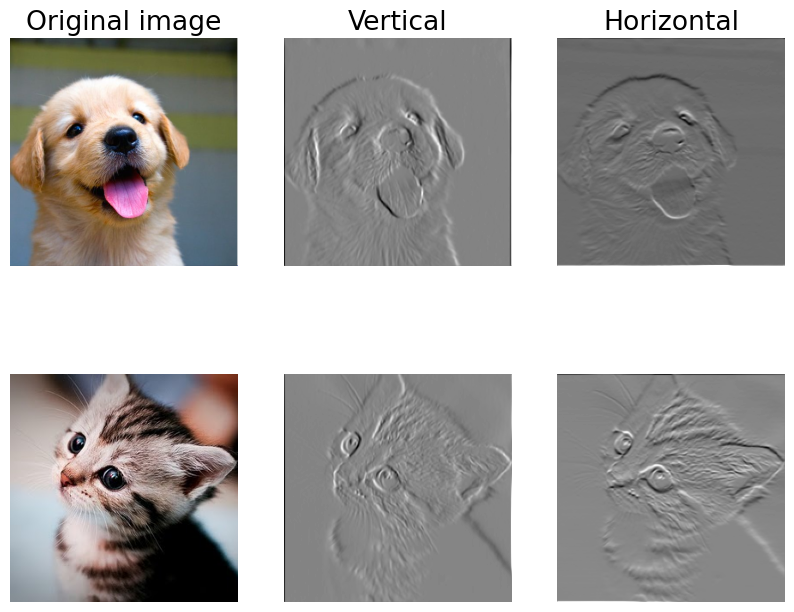

In [ ]:
from imageio import imread
from PIL import Image
from torchvision.transforms import ToTensor

kitten_url = 'https://web.eecs.umich.edu/~justincj/teaching/eecs498/assets/a3/kitten.jpg'
puppy_url = 'https://web.eecs.umich.edu/~justincj/teaching/eecs498/assets/a3/puppy.jpg'

kitten = imread(kitten_url)
puppy = imread(puppy_url)
# kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, d//2:-d//2, :]

img_size = 200   # Make this smaller if it runs too slow
resized_puppy = ToTensor()(Image.fromarray(puppy).resize((img_size, img_size)))
resized_kitten = ToTensor()(Image.fromarray(kitten_cropped).resize((img_size, img_size)))
x = torch.stack([resized_puppy, resized_kitten])

# Set up a convolutional weights holding 2 filters, each 3x3
w = torch.zeros(2, 3, 3, 3, dtype=x.dtype)
# The first filter detects vertical edges.
w[0, 0, :, :] = torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
w[0, 1, :, :] = torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
w[0, 2, :, :] = torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]])

# Second filter detects horizontal edges.
w[1, 0, :, :] = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
w[1, 1, :, :] = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
w[1, 2, :, :] = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

# Vector of biases. For the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = torch.tensor([128, 128], dtype=x.dtype)

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out, _ = Conv.forward(x, w, b, {'stride': 1, 'pad': 1})

def imshow_no_ax(img):
  """ Tiny helper to show images as uint8 and remove axis labels """
  plt.imshow(img, cmap='gray')
  plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_no_ax(puppy)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_no_ax(out[0, 0])
plt.title('Vertical')
plt.subplot(2, 3, 3)
imshow_no_ax(out[0, 1])
plt.title('Horizontal')
plt.subplot(2, 3, 4)
imshow_no_ax(kitten_cropped)
plt.subplot(2, 3, 5)
imshow_no_ax(out[1, 0])
plt.subplot(2, 3, 6)
imshow_no_ax(out[1, 1])
plt.show()

# Max-pooling

## Max-pooling: forward
Here you'll implement the forward pass for the max-pooling operation.

Head over to the TODO for `forward` function in `MaxPool` class. Once you complete that, run the following to check your implementation. You should get errors less than `1e-7`.


In [ ]:
from convolutional_networks import MaxPool

reset_seed(0)
x_shape = torch.tensor((2, 3, 4, 4))
x = torch.linspace(-0.3, 0.4, steps=torch.prod(x_shape), dtype=torch.float64, device=DEVICE).reshape(*x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out, _ = MaxPool.forward(x, pool_param)

correct_out = torch.tensor([[[[-0.26315789, -0.24842105],
                              [-0.20421053, -0.18947368]],
                             [[-0.14526316, -0.13052632],
                              [-0.08631579, -0.07157895]],
                             [[-0.02736842, -0.01263158],
                              [ 0.03157895,  0.04631579]]],
                            [[[ 0.09052632,  0.10526316],
                              [ 0.14947368,  0.16421053]],
                             [[ 0.20842105,  0.22315789],
                              [ 0.26736842,  0.28210526]],
                             [[ 0.32631579,  0.34105263],
                              [ 0.38526316,  0.4       ]]]],
                           dtype=torch.float64, device=DEVICE)

# Compare your output with ours. Difference should be on the order of e-8.
print('Testing MaxPool.forward function:')
print('difference: ', cs6476.grad.rel_error(out, correct_out))

Testing MaxPool.forward function:
difference:  1.9824600077610733e-08


# Fast layers
You must have noticed the amount of time it takes for these layers to execute for an image (edge filter example had 1 layer with 2 filters). Now imagine if there are multiple such layers with 100s of filters. For example, VGG has 13 conv layers with the number of filters per layer increasing progressively (64, 128, 256, 512). Seems like it would take forever to execute.

No need to worry! There is a library that implements it very efficiently for you. The `torch.nn` library offers fast implementations of convolution and pooling layers by harnessing GPU acceleration, optimized algorithms, and efficient memory management. It leverages hardware acceleration and multi-threading, processes batches efficiently, and integrates with BLAS (fancy C libraries) for high-performance linear algebra operations.

Let's learn how we can use this tool.


Take a look at the following code for implementing convolutional layer using `torch.nn`.

```python
class FastConv(object):
    @staticmethod
    def forward(x, w, b, conv_param):
        # Extract shapes and convolution parameters
        N, C, H, W = x.shape
        F, _, HH, WW = w.shape
        stride, pad = conv_param['stride'], conv_param['pad']
        # Create a 2D convolution layer using PyTorch's built-in Conv2d
        layer = torch.nn.Conv2d(C, F, (HH, WW), stride=stride, padding=pad)
        # Set the layer's weights and biases to the provided values
        layer.weight = torch.nn.Parameter(w)
        layer.bias = torch.nn.Parameter(b)
        # Detach the input tensor and enable gradient computation
        tx = x.detach()
        tx.requires_grad = True
        # Forward pass through the convolutional layer
        out = layer(tx)
        # Cache relevant information for the backward pass
        cache = (x, w, b, conv_param, tx, out, layer)
        # Return the output and cache
        return out, cache

    @staticmethod
    def backward(dout, cache):
        try:
            # Unpack cached values
            x, _, _, _, tx, out, layer = cache
            # Perform backward pass through PyTorch's autograd
            out.backward(dout)
            # Extract gradients from the intermediate tensor and detach them
            dx = tx.grad.detach()
            dw = layer.weight.grad.detach()
            db = layer.bias.grad.detach()
            # Reset gradients in the layer to avoid accumulation
            layer.weight.grad = layer.bias.grad = None
        except RuntimeError:
            # Handle exceptions, e.g., if the autograd graph is not connected
            dx, dw, db = torch.zeros_like(tx), \
                         torch.zeros_like(layer.weight), \
                         torch.zeros_like(layer.bias)
        # Return computed gradients
        return dx, dw, db

```
Above class is also implemented at the bottom of `convolutional_networks.py`


Let's use the above and compare with our previous implementations of convolution (both forward and backward):

1. Your naive, non-vectorized implementation on CPU
2. The fast, vectorized implementation on CPU
3. The fast, vectorized implementation on GPU

The differences between your implementation and FastConv should be less than `1e-10`.

In [ ]:
# Rel errors should be around e-11 or less
from convolutional_networks import Conv, FastConv

reset_seed(903226690)
x = torch.randn(10, 3, 31, 31, dtype=torch.float64)
w = torch.randn(25, 3, 3, 3, dtype=torch.float64)
b = torch.randn(25, dtype=torch.float64)
dout = torch.randn(10, 25, 16, 16, dtype=torch.float64)
x_cuda, w_cuda, b_cuda, dout_cuda = x.to(DEVICE), w.to(DEVICE), b.to(DEVICE), dout.to(DEVICE)
conv_param = {'stride': 2, 'pad': 1}

t0 = time.time()
out_naive, cache_naive = Conv.forward(x, w, b, conv_param)
t1 = time.time()
out_fast, cache_fast = FastConv.forward(x, w, b, conv_param)
t2 = time.time()
out_fast_cuda, cache_fast_cuda = FastConv.forward(x_cuda, w_cuda, b_cuda, conv_param)
t3 = time.time()

print('Testing FastConv.forward:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Fast CUDA: %fs' % (t3 - t2))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Speedup CUDA: %fx' % ((t1 - t0) / (t3 - t2)))
print('Difference: ', cs6476.grad.rel_error(out_naive, out_fast))
print('Difference CUDA: ', cs6476.grad.rel_error(out_naive, out_fast_cuda.to(out_naive.device)))

Testing FastConv.forward:
Naive: 2.664612s
Fast: 0.017993s
Fast CUDA: 0.001148s
Speedup: 148.093750x
Speedup CUDA: 2321.119626x
Difference:  2.043108449329583e-08
Difference CUDA:  2.043108449329583e-08


Take a look at the following code for implementing MaxPool using torch
```python
class FastMaxPool(object):
    @staticmethod
    def forward(x, pool_param):
        # Extract shapes and pooling parameters
        N, C, H, W = x.shape
        pool_height, pool_width = \
            pool_param['pool_height'], pool_param['pool_width']
        stride = pool_param['stride']
        # Create a 2D max pooling layer using PyTorch's built-in MaxPool2d
        layer = torch.nn.MaxPool2d(kernel_size=(pool_height, pool_width),
                                   stride=stride)
        # Detach the input tensor and enable gradient computation
        tx = x.detach()
        tx.requires_grad = True
        # Forward pass through the max pooling layer
        out = layer(tx)
        # Cache relevant information for the backward pass
        cache = (x, pool_param, tx, out, layer)
        # Return the output and cache
        return out, cache

    @staticmethod
    def backward(dout, cache):
        try:
            # Unpack cached values
            x, _, tx, out, layer = cache
            # Perform backward pass through PyTorch's autograd
            out.backward(dout)
            # Extract gradients from the intermediate tensor and detach them
            dx = tx.grad.detach()
        except RuntimeError:
            # Handle exceptions, e.g., if the autograd graph is not connected
            dx = torch.zeros_like(tx)
        # Return computed gradients
        return dx
```

We will now similarly compare your naive implementation of max pooling against the fast implementation. You should see differences of 0 between your implementation and the fast implementation.


In [ ]:
# Relative errors should be close to 0.0
from convolutional_networks import Conv, MaxPool, FastConv, FastMaxPool


reset_seed(903322690)
x = torch.randn(40, 3, 32, 32, dtype=torch.float64)
dout = torch.randn(40, 3, 16, 16, dtype=torch.float64)
x_cuda, dout_cuda = x.to(DEVICE), dout.to(DEVICE)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

t0 = time.time()
out_naive, cache_naive = MaxPool.forward(x, pool_param)
t1 = time.time()
out_fast, cache_fast = FastMaxPool.forward(x, pool_param)
t2 = time.time()
out_fast_cuda, cache_fast_cuda = FastMaxPool.forward(x_cuda, pool_param)
t3 = time.time()

print('Testing FastMaxPool.forward:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Fast CUDA: %fs' % (t3 - t2))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Speedup CUDA: %fx' % ((t1 - t0) / (t3 - t2)))
print('Difference: ', cs6476.grad.rel_error(out_naive, out_fast))
print('Difference CUDA: ', cs6476.grad.rel_error(out_naive, out_fast_cuda.to(out_naive.device)))

Testing FastMaxPool.forward:
Naive: 0.883487s
Fast: 0.005143s
Fast CUDA: 0.001233s
Speedup: 171.794715x
Speedup CUDA: 716.614195x
Difference:  1.8112073919666767e-08
Difference CUDA:  1.8112073919666767e-08


# Combining Layers

Study the following code for creating a custom layer that performs a convolution followed by a ReLU
```python
class Conv_ReLU(object):
    @staticmethod
    def forward(x, w, b, conv_param):
        """
        Inputs:
        - x: Input to the convolutional layer
        - w, b, conv_param: Weights and parameters for the
          convolutional layer
        Returns a tuple of:
        - out: Output from the ReLU
        - cache: Object to give to the backward pass
        """
        # Forward pass through FastConv and ReLU layers
        a, conv_cache = FastConv.forward(x, w, b, conv_param)  # Perform convolution
        out, relu_cache = ReLU.forward(a)  # Apply ReLU activation
        cache = (conv_cache, relu_cache)  # Cache convolution and ReLU results
        return out, cache

    @staticmethod
    def backward(dout, cache):
        # Backward pass for the Conv_ReLU layer
        conv_cache, relu_cache = cache
        da = ReLU.backward(dout, relu_cache)  # Backpropagate through ReLU
        dx, dw, db = FastConv.backward(da, conv_cache)  # Backpropagate through convolution
        return dx, dw, db
```

Now you'll implement another custom layer that performs a convolution, a ReLU, and a pool.

Complete the TODO for `forward` function in `Conv_ReLU_Pool` class. Once you complete that, run the following to check your implementation. You should get errors less than `1e-5`.

In [ ]:
from convolutional_networks import Conv_ReLU_Pool

x_shape = torch.tensor((2, 3, 4, 4))
w_shape = torch.tensor((3, 3, 4, 4))
x = torch.linspace(-0.1, 0.5, steps=torch.prod(x_shape), dtype=torch.float64, device=DEVICE).reshape(*x_shape)
w = torch.linspace(-0.2, 0.3, steps=torch.prod(w_shape), dtype=torch.float64, device=DEVICE).reshape(*w_shape)
b = torch.linspace(-0.1, 0.2, steps=3, dtype=torch.float64, device=DEVICE)

conv_param = {'stride': 2, 'pad': 1}
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}
out, cache = Conv_ReLU_Pool.forward(x, w, b, conv_param, pool_param)
correct_out = torch.tensor([[[[0.0000]],
                          [[0.2300]],
                          [[0.6710]]],
                          [[[0.0000]],
                          [[0.6911]],
                          [[2.3825]]]], dtype=torch.float64, device=DEVICE,
            )

# Compare your output to ours; difference should be around e-8
print('Testing Conv.forward')
print('difference: ', cs6476.grad.rel_error(out, correct_out))

Testing Conv.forward
difference:  9.73240031539542e-06


# Three-layer convolutional network

Now that you've implemented all the required layers, you can combine them to create a simple convolutional network. To do this, complete the TODO for the ThreeLayerConvNet class. This network consists of 3 layers one after the other. conv_relu_pool -> linear_relu -> linear softmax.

There are in total 4 TODOs in this class.
1. Initializing the network: Using the inputs, initialize weights and biases for all three layer.
2. Implement the forward pass
3. The backward pass is already implemented, you are supposed to incorporate L2 regularization into loss.
4. Assign 2nd output (cache) of the custom forward layers to specific variables. This is a small but important book-keeping step to calculate correct gradients.

Follow the TODO for further details.

Once you are done, you can run the following cells to assist you in debugging and ensuring your network is working correctly.

Refer to the following formula for adding regularization term to loss

$regularized\_loss = loss + \lambda \sum_{j}w_j^2$


## Debugging: Loss check
when using the softmax loss, you should expect the loss for random weights (without regularization) to be approximately log(C) for C classes. When you introduce regularization, the loss should increase slightly. This is an important step to verify that your network is behaving as expected and that the loss is within the anticipated range.

In [ ]:
from convolutional_networks import ThreeLayerConvNet

reset_seed(903322690)
model = ThreeLayerConvNet(dtype=torch.float64, device=DEVICE)

N = 50
X = torch.randn(N, 3, 32, 32, dtype=torch.float64, device=DEVICE)
y = torch.randint(10, size=(N,), dtype=torch.int64, device=DEVICE)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss.item())

model.reg = 0.5
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss.item())

Initial loss (no regularization):  2.302585233676965
Initial loss (with regularization):  2.715244088116233


## Debugging: Gradient check
Once you've verified that the loss behaves reasonably, the next step is to use numeric gradient checking to ensure the correctness of your backward pass. Numeric gradient checking involves using a small amount of synthetic data and a limited number of neurons at each layer.

You should get errors that are less than `1e-7`. This procedure helps confirm the accuracy of your network's gradient calculations and ensures that the gradients match what's expected for backpropagation.

In [ ]:
from convolutional_networks import ThreeLayerConvNet

num_inputs = 2
input_dims = (3, 16, 16)
reg = 0.0
num_classes = 10
reset_seed(0)
X = torch.randn(num_inputs, *input_dims, dtype=torch.float64, device=DEVICE)
y = torch.randint(num_classes, size=(num_inputs,), dtype=torch.int64, device=DEVICE)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dims=input_dims, hidden_dim=7,
                          weight_scale=5e-2, dtype=torch.float64, device=DEVICE)
loss, grads = model.loss(X, y)

for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = cs6476.grad.compute_numeric_gradient(f, model.params[param_name])
    print('%s max relative error: %e' % (param_name, cs6476.grad.rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 1.596974e-08
W2 max relative error: 3.008903e-08
W3 max relative error: 5.881086e-09
b1 max relative error: 1.360193e-08
b2 max relative error: 6.152951e-09
b3 max relative error: 1.048590e-09


## Debugging: Overfiting on small data
A useful technique is to train your model using a small subset of the training data. This approach allows you to intentionally overfit the model to the small dataset, leading to exceptionally high training accuracy while observing relatively lower validation accuracy.

In [ ]:
from convolutional_networks import ThreeLayerConvNet
from fully_connected_networks import adam

reset_seed(903322690)

num_train = 100
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-3, dtype=torch.float32, device=DEVICE)

solver = Solver(model, small_data,
                num_epochs=30, batch_size=50,
                update_rule=adam,
                optim_config={
                  'learning_rate': 2e-3,
                },
                verbose=True, print_every=10,
                device=DEVICE)
solver.train()

(Time 0.18 sec; Iteration 1 / 60) loss: 2.302585
(Epoch 0 / 30) train acc: 0.160000; val_acc: 0.102000
(Epoch 1 / 30) train acc: 0.170000; val_acc: 0.103200
(Epoch 2 / 30) train acc: 0.170000; val_acc: 0.102000
(Epoch 3 / 30) train acc: 0.170000; val_acc: 0.102900
(Epoch 4 / 30) train acc: 0.190000; val_acc: 0.113900
(Epoch 5 / 30) train acc: 0.240000; val_acc: 0.136500
(Time 30.66 sec; Iteration 11 / 60) loss: 2.090852
(Epoch 6 / 30) train acc: 0.300000; val_acc: 0.157300
(Epoch 7 / 30) train acc: 0.290000; val_acc: 0.154400
(Epoch 8 / 30) train acc: 0.370000; val_acc: 0.150000
(Epoch 9 / 30) train acc: 0.420000; val_acc: 0.157300
(Epoch 10 / 30) train acc: 0.430000; val_acc: 0.159900
(Time 54.88 sec; Iteration 21 / 60) loss: 1.531814
(Epoch 11 / 30) train acc: 0.520000; val_acc: 0.163800
(Epoch 12 / 30) train acc: 0.510000; val_acc: 0.159800
(Epoch 13 / 30) train acc: 0.660000; val_acc: 0.166700
(Epoch 14 / 30) train acc: 0.640000; val_acc: 0.171000
(Epoch 15 / 30) train acc: 0.69000

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

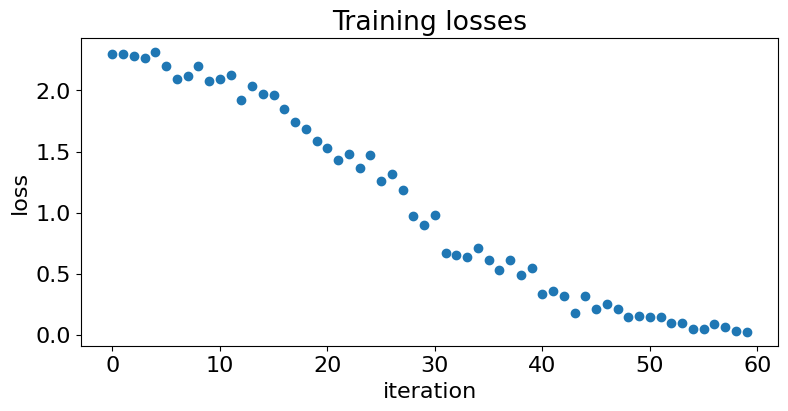

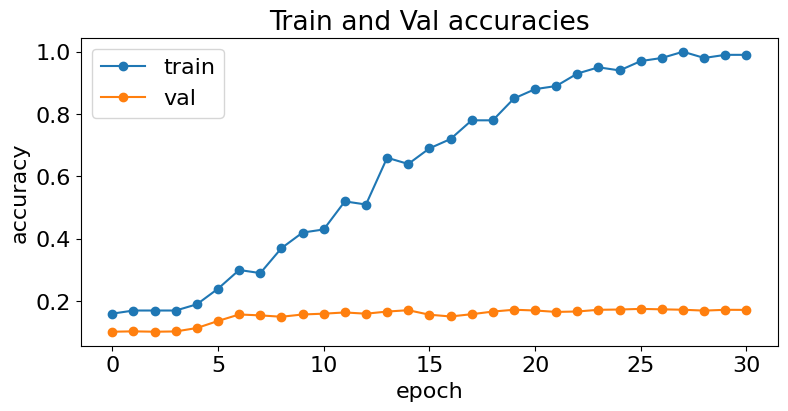

In [ ]:
plt.title('Training losses')
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.gcf().set_size_inches(9, 4)
plt.show()

plt.title('Train and Val accuracies')
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.gcf().set_size_inches(9, 4)
plt.show()

## Train your network
Training the three-layer convolutional network for a single epoch should result in a training set accuracy exceeding 50%.

In [ ]:
from convolutional_networks import ThreeLayerConvNet
from fully_connected_networks import adam

reset_seed(903322690)

model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=100, reg=0.001, dtype=torch.float, device=DEVICE)

solver = Solver(model, data_dict,
                num_epochs=1, batch_size=64,
                update_rule=adam,
                optim_config={
                  'learning_rate': 2e-3,
                },
                verbose=True, print_every=100, device=DEVICE)
solver.train()

(Time 0.11 sec; Iteration 1 / 625) loss: 2.303411
cpu
(Epoch 0 / 1) train acc: 0.094000; val_acc: 0.100300
(Time 15.82 sec; Iteration 101 / 625) loss: 1.916951
(Time 27.26 sec; Iteration 201 / 625) loss: 1.708181
(Time 38.66 sec; Iteration 301 / 625) loss: 1.647124
(Time 49.89 sec; Iteration 401 / 625) loss: 1.624739
(Time 59.86 sec; Iteration 501 / 625) loss: 1.555768
(Time 71.26 sec; Iteration 601 / 625) loss: 1.625119
cpu
(Epoch 1 / 1) train acc: 0.508000; val_acc: 0.505400


## Visualize Filters
You can visualize the first-layer convolutional filters from the trained network by running the following:

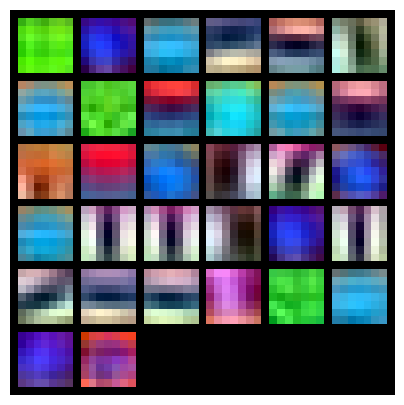

In [ ]:
from torchvision.utils import make_grid
nrow = math.ceil(math.sqrt(model.params['W1'].shape[0]))
grid = make_grid(model.params['W1'], nrow=nrow, padding=1, normalize=True, scale_each=True)
plt.imshow(grid.to(device=DEVICE).permute(1, 2, 0))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

# Train a good model!
Now it's time to play with the model that you have implemented. Following are the hyperparameters that you can play with:
1. number of filters
2. filter_size
3. hidden layer dimension
4. regularizer gain
5. weight scale (used for initialization)
6. learning rate
7. num_epochs
8. batch size
9. optimizer (viz. adam, sgd, sgd momentum)

1 to 5 are model hyperparameters, 6 to 9 are training process hyperparameters.
Tweak these and train the best model that you can on CIFAR-10.

Set the hyperparameter of your choice in the cell below and test your model.

HINT: Following are the typical values of respective hyperparameters that you can use as a starting point (index same as the above list)
1. 4, 8, 64, 128
2. 3, 5, 7
2. 50, 100, 200, 500
4. 0.1, 0.01, 0.001, 0.0001
5. 0.001
6. 0.01, 0.001, 0.0001
7. 10, 30, 50
8. 8, 32, 64, 128

In [ ]:
from convolutional_networks import ThreeLayerConvNet
from fully_connected_networks import adam

reset_seed(903322690)

#### put the values of your choice below ####
num_filters = 64
filter_size = 5
hidden_dim = 200
reg = 0.01
weight_scale = 1e-3
learning_rate = 1e-3
num_epochs = 30
batch_size = 128
#############################################
model = ThreeLayerConvNet(num_filters=num_filters, filter_size=filter_size, hidden_dim=hidden_dim, reg=reg, weight_scale=weight_scale, dtype=torch.float, device='cuda')

solver = Solver(model, data_dict,
                num_epochs=num_epochs, batch_size=batch_size,
                update_rule=adam,
                optim_config={
                  'learning_rate': learning_rate,
                },
                verbose=True, print_every=10000, device='cuda')
solver.train()

(Time 1.63 sec; Iteration 1 / 9360) loss: 2.335425
cuda
(Epoch 0 / 30) train acc: 0.091000; val_acc: 0.101400
cuda
(Epoch 1 / 30) train acc: 0.360000; val_acc: 0.353700
cuda
(Epoch 2 / 30) train acc: 0.404000; val_acc: 0.394200
cuda
(Epoch 3 / 30) train acc: 0.428000; val_acc: 0.454800
cuda
(Epoch 4 / 30) train acc: 0.468000; val_acc: 0.475200
cuda
(Epoch 5 / 30) train acc: 0.494000; val_acc: 0.491800
cuda
(Epoch 6 / 30) train acc: 0.495000; val_acc: 0.493100
cuda
(Epoch 7 / 30) train acc: 0.504000; val_acc: 0.504300
cuda
(Epoch 8 / 30) train acc: 0.528000; val_acc: 0.513900
cuda
(Epoch 9 / 30) train acc: 0.530000; val_acc: 0.518200
cuda
(Epoch 10 / 30) train acc: 0.556000; val_acc: 0.519200
cuda
(Epoch 11 / 30) train acc: 0.551000; val_acc: 0.513000
cuda
(Epoch 12 / 30) train acc: 0.564000; val_acc: 0.521700
cuda
(Epoch 13 / 30) train acc: 0.548000; val_acc: 0.526300
cuda
(Epoch 14 / 30) train acc: 0.557000; val_acc: 0.526600
cuda
(Epoch 15 / 30) train acc: 0.525000; val_acc: 0.527000

In [ ]:
# Test your model
print('Validation set accuracy: ', solver.check_accuracy(data_dict['X_val'], data_dict['y_val']))
print('Test set accuracy: ', solver.check_accuracy(data_dict['X_test'], data_dict['y_test']))

Validation set accuracy:  0.5471999645233154
Test set accuracy:  0.5561999678611755


If you're happy with the model's perfromance, run the following cell to save it.

We will also reload the model and run it on the training data to verify it's the right weights.

In [ ]:
path = os.path.join(GOOGLE_DRIVE_PATH, 'final_threeconvnet.pth')
solver.model.save(path)

Saved in drive/My Drive/CS 6476 Intro to Computer Vision/Assignment 2/final_threeconvnet.pth


# SUBMITTING YOUR WORK
Put in the final choice of hyperparameters inside the function in below cell. At the very bottom the `convolutional_network.py` file the same function is already there, just put your final parameters in that function.
This is important for us to evaluate your final model.

NOTE: Put in the same params that you used to train and save the above model

In [ ]:
def create_convolutional_solver_instance(data_dict, dtype, device):

    #### put your final hyperparameters here ####
    num_filters = 64
    filter_size = 7
    hidden_dim = 200
    reg = 0.01
    weight_scale = 1e-3
    learning_rate = 0.001
    num_epochs = 30
    batch_size = 128
    #############################################

    input_dims = data_dict['X_train'].shape[1:]
    model = ThreeLayerConvNet(num_filters=num_filters, filter_size=filter_size,
                              hidden_dim=hidden_dim, reg=reg, weight_scale=weight_scale,
                              dtype=torch.float, device=DEVICE)

    solver = Solver(model, data_dict,
                    num_epochs=num_epochs, batch_size=batch_size,
                    update_rule=adam,
                    optim_config={
                      'learning_rate': learning_rate,
                    },
                    device=DEVICE)
    return solver